In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import networkx as nx
from cdlib import algorithms, viz, evaluation
import copy

In [43]:
with open('../pkl/global_weekly_sorted_tensor2.pkl', 'rb') as f:
    travel_tensor_raw = pickle.load(f) 

with open('../pkl/global_weekly_graphs2.pkl', 'rb') as f:
    serial_graphs = pickle.load(f) 

In [44]:
with open('../pkl/new_country_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [45]:
country_cutline = 30 # 69, 70 give None homogeneity
travel_tensors = travel_tensor_raw[:,0:country_cutline,0:country_cutline]

In [46]:
travel_df = pd.read_csv('../csv/global_travel_df.csv')
countries = travel_df['node'].unique().T

In [47]:
label_dict = dict(zip(np.char.mod('%d', range(226)), countries[new_order]))
label_dict = dict(zip(range(30), countries[new_order]))

In [48]:
adj_list = []
interval = 50 # 26 * 4 weeks = 2 year,
for i in range(interval):
    ajm = np.sum(travel_tensors[4*i:4 + 4*i][:,0:country_cutline,0:country_cutline], axis=0)
    adj_list.append(ajm)
travel_tensors = np.array(adj_list)

In [49]:
label_dict

{0: 'US',
 1: 'GB',
 2: 'FR',
 3: 'ES',
 4: 'IT',
 5: 'DE',
 6: 'MX',
 7: 'CA',
 8: 'JP',
 9: 'NL',
 10: 'BR',
 11: 'TH',
 12: 'ID',
 13: 'MY',
 14: 'SG',
 15: 'BE',
 16: 'AE',
 17: 'AU',
 18: 'CH',
 19: 'PH',
 20: 'IE',
 21: 'PT',
 22: 'AR',
 23: 'TR',
 24: 'RU',
 25: 'KW',
 26: 'CN',
 27: 'IN',
 28: 'HK',
 29: 'AT'}

# Ego tensor

In [50]:
def ego_trans(cnt_num, original_tensors):
    travel_tensors = copy.deepcopy(original_tensors)
    egotensor = []
    for mat in travel_tensors:
        for r in range(mat.shape[0]):
            for c in range(mat.shape[1]):        
                if(r!=cnt_num and c!=cnt_num):
                    mat[r,c]=0
        egotensor.append(mat)
    egotensor = np.array(egotensor)
    return egotensor

In [51]:
egotensor = ego_trans(12, travel_tensors)

In [52]:
egotensor.shape

(50, 30, 30)

# Average community

In [53]:
avg_adj = np.mean(egotensor[0:50,:,:], 0)

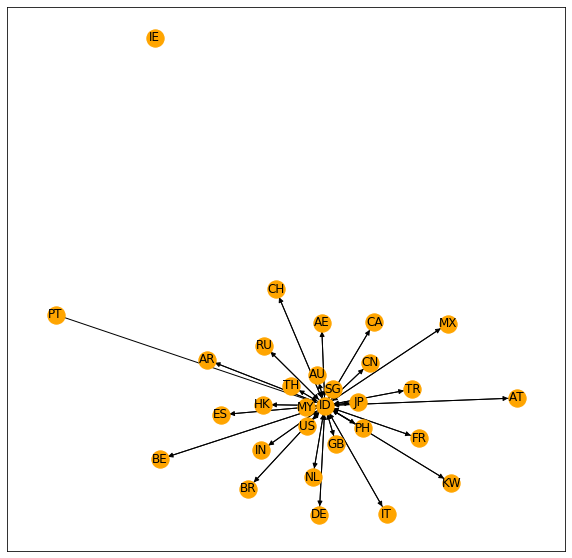

In [54]:
temp_G = nx.from_numpy_matrix(avg_adj, create_using=nx.DiGraph)
G = nx.relabel_nodes(temp_G, label_dict)
pos = nx.spring_layout(G)
plt.figure(figsize=(10,10)) 
nx.draw_networkx(G, pos, node_color='orange')

In [55]:
adjmat = nx.to_numpy_array(G)

df = pd.DataFrame([[-1,-1,-1]])
for i in range(adjmat.shape[0]):
    for j in range(adjmat.shape[1]):
        if(adjmat[i,j]==0):
            continue
        else:
            a_row = pd.Series([label_dict[i], label_dict[j], adjmat[i,j]])
            row_df = pd.DataFrame([a_row])
            df = pd.concat([df, row_df])
#         df = pd.DataFrame(pd.Series(i,j,adjmat[i,j]), index=range(1),columns=['from','to','weight'])
df = df.iloc[1:,:]
df.columns = ['Source','Target','Weight']
df.to_csv("egonet_RU.csv", index =False)

In [56]:
# coms.communities
# 8, 9, 10, 11, 13, 16, 18, 19, 26, 27, 28
# 2, 3, 5, 12, 20, 23, 24, 25, 29
# 1, 4, 15, 17, 21
# 0, 6, 7, 14, 22

# Anomaly detection

In [57]:
travel_local = egotensor

In [58]:
travel_local.shape

(50, 30, 30)

In [59]:
# local = [0,1, 24]
# travel_local = travel_tensors[:,local][:,:,local]

In [60]:
out_d_ar = []; out_w_ar = []; in_d_ar = []; in_w_ar = []; neig_ar = []; recep_n_ar = []; tri_ar = []
avg_iw_ar = []; avg_ow_ar = []; max_iw_ar = []; max_ow_ar = []; max_wr_ar = []

In [61]:
Time_interval = 50

for mat_t in travel_local[-Time_interval:]:
# adj_mat=travel_tensor[100][:,:226]
    adj_mat = mat_t[:,:travel_local.shape[1]]
    adj_bool = (adj_mat >0).astype(int)
    # print(adj_mat)

    out_degree = np.sum(adj_bool, axis=1) ; out_d_ar.append(out_degree)
    out_weight = np.sum(adj_mat, axis=1) ; out_w_ar.append(out_weight)
    in_degree = np.sum(adj_bool, axis=0) ; in_d_ar.append(in_degree)
    in_weight = np.sum(adj_mat, axis=0) ; in_w_ar.append(in_weight)
    neighbors = np.sum((adj_bool + adj_bool.T)>0, axis=1) ; neig_ar.append(neighbors)
    recp_nb = np.sum((adj_bool + adj_bool.T)==2, axis=1) ; recep_n_ar.append(recp_nb)
    tri = np.diag(np.matmul(adj_bool, adj_bool, adj_bool)) ; tri_ar.append(tri)

    avg_in_w = np.divide(in_weight, in_degree, out = np.zeros_like(in_degree.astype(float)), where= in_degree!=0)
    avg_iw_ar.append(avg_in_w)
    avg_out_w = np.divide(out_weight, out_degree, out = np.zeros_like(out_degree.astype(float)), where= out_degree!=0)
    avg_ow_ar.append(avg_out_w)
    
    max_in_w = np.max(adj_mat, axis=0) ;  max_iw_ar.append(max_in_w)
    max_out_w = np.max(adj_mat, axis=1) ;  max_ow_ar.append(max_out_w)
    max_w_ratio = np.max(np.divide(adj_mat, adj_mat.T, out=np.zeros_like(adj_mat.T), where=adj_mat.T!=0), axis=1)
    max_wr_ar.append(max_w_ratio)

In [62]:
np.max([[1,2],[3,4]], 1)

array([2, 4])

In [63]:
week_slices = pd.date_range('2016-01-04', periods=200+1, freq='W')

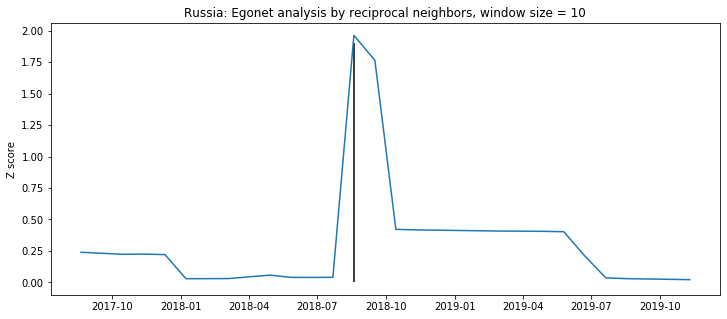

In [78]:
W = 10
# feat_arr = [out_d_ar, out_w_ar, in_d_ar, in_w_ar, neig_ar, recep_n_ar, tri_ar, avg_iw_ar, avg_ow_ar, max_iw_ar, max_ow_ar, max_wr_ar]
feat_arr = [recep_n_ar]
# feat_title = ['out_d_ar', 'out_w_ar', 'in_d_ar', 'in_w_ar', 'neig_ar', 'recep_n_ar', 'tri_ar', 'avg_iw_ar', 'avg_ow_ar', 'max_iw_ar', 'max_ow_ar', 'max_wr_ar']
feat_title = ['Russia: Egonet analysis by reciprocal neighbors']
z_collection = []
iter = 0
#############################################################################
# different pattern from LOF of TBAD
# more stationary. 
# in_d: reasoanble seasonality. star to incrase from July
#############################################################################
for feature in feat_arr:
    feat = feature # out_w_ar, recep_n_ar
    cov_series = []
    for t in range(W, len(feat)):
        C = np.cov(np.array(feat)[t-W:t].T)
        cov_series.append(C)

    u1_list = []
    for i in cov_series:
        U, S, V =np.linalg.svd(i)
        u1_list.append(U[:,0])

    z_list = []
    for i in range(W, len(u1_list)):
        utv = np.dot(u1_list[i], np.mean(np.array(u1_list[i-W:i]), axis=0))
        z = 1-1* utv
        z_list.append(z)
    #############################################################################

#     week_slices = pd.date_range('2016-01-04', periods=200, freq='W')
    xaxis = week_slices[0::4][-Time_interval+2*W:]
    plt.figure(figsize=(12,5))
    plt.plot(xaxis, z_list)
    plt.vlines(xaxis[-17], 0, 1.9)
    plt.ylabel("Z score")
#     plt.plot(range(-Time_interval+2*W + 40, -40), z_list[40:-40])
    plt.title(feat_title[iter]+ ", window size = " +str(W))
    iter +=1
    #############################################################################
    z_collection.append(np.array(z_list))

In [80]:
xaxis[-15]

Timestamp('2018-10-14 00:00:00', freq='4W-SUN')

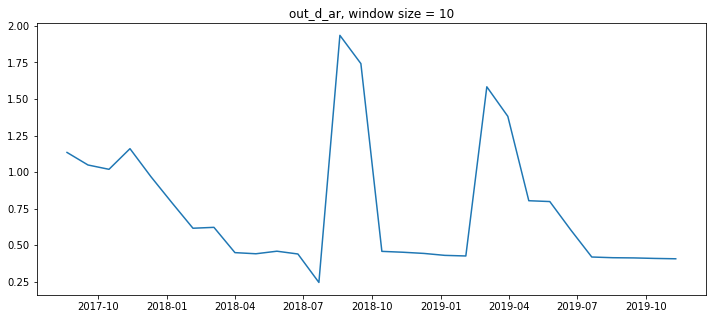

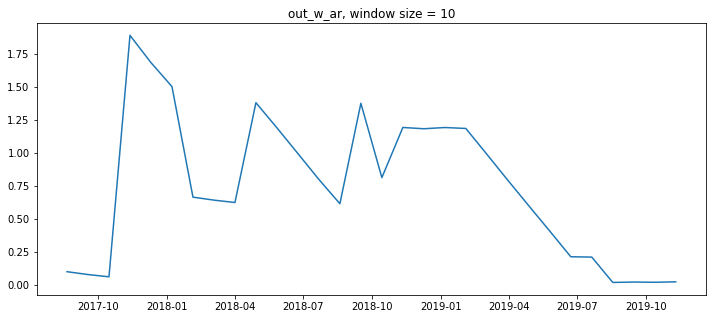

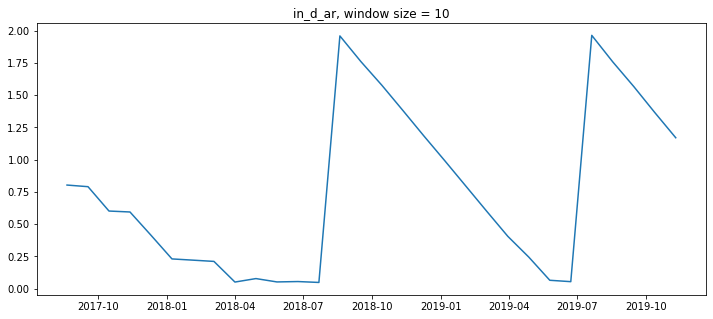

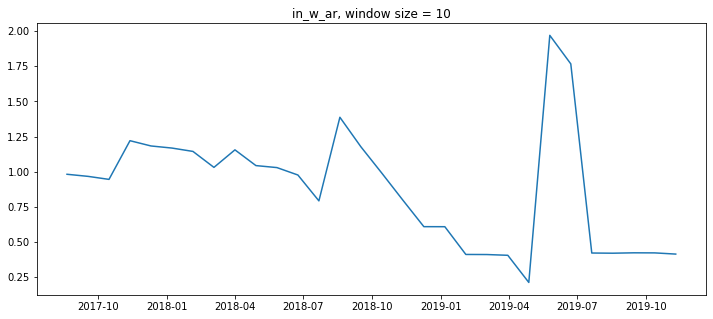

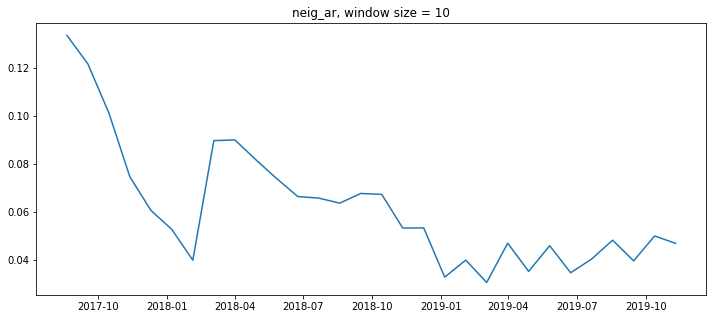

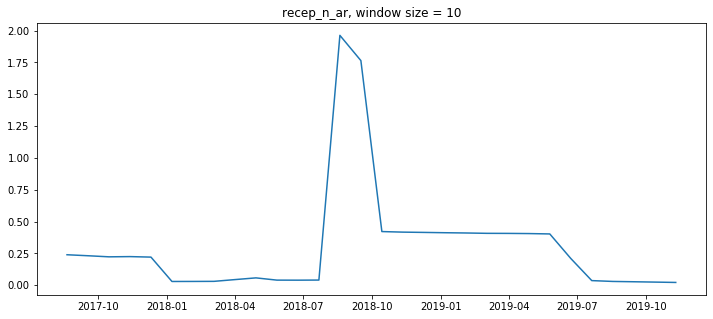

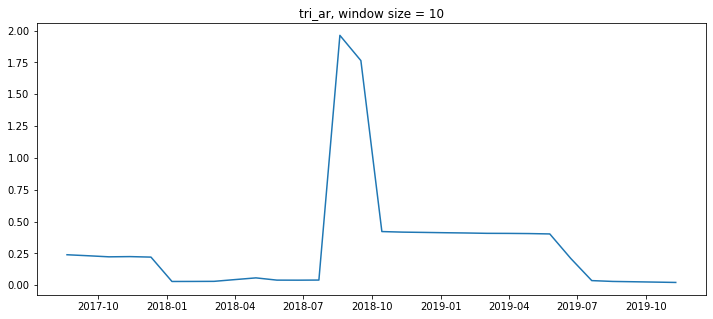

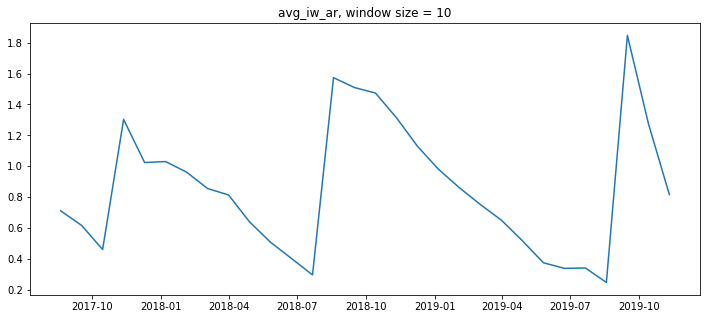

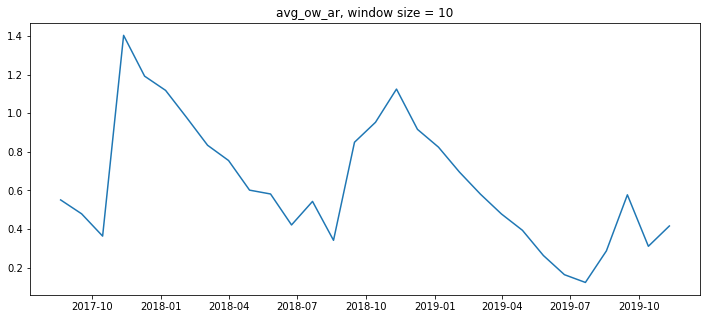

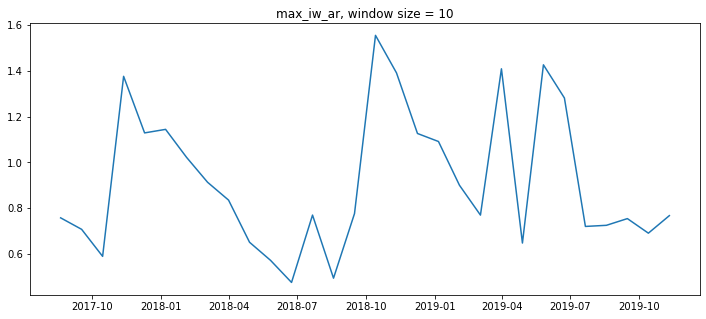

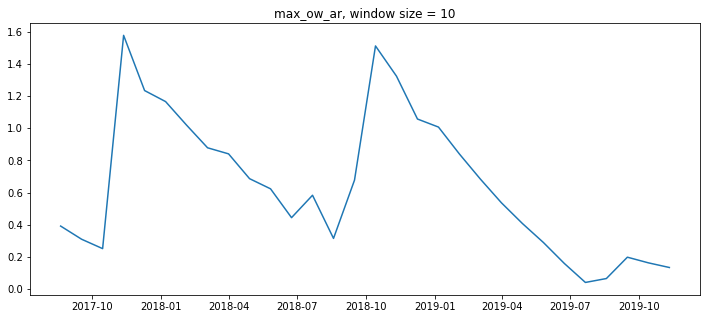

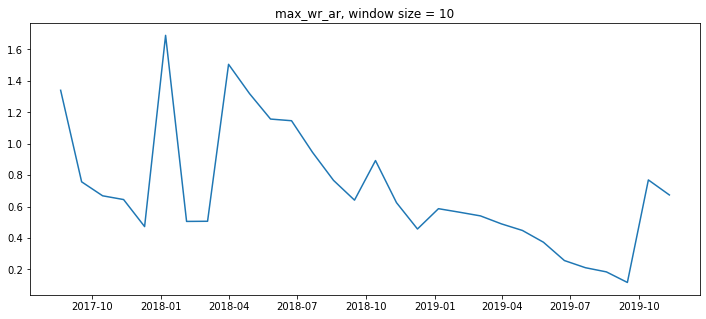

In [83]:
W = 10
feat_arr = [out_d_ar, out_w_ar, in_d_ar, in_w_ar, neig_ar, recep_n_ar, tri_ar, avg_iw_ar, avg_ow_ar, max_iw_ar, max_ow_ar, max_wr_ar]
# feat_arr = [out_w_ar, in_d_ar,neig_ar,avg_ow_ar]
feat_title = ['out_d_ar', 'out_w_ar', 'in_d_ar', 'in_w_ar', 'neig_ar', 'recep_n_ar', 'tri_ar', 'avg_iw_ar', 'avg_ow_ar', 'max_iw_ar', 'max_ow_ar', 'max_wr_ar']
# feat_title = ['out_w_ar', 'in_d_ar','neig_ar','avg_ow_ar']
z_collection = []
iter = 0
#############################################################################
# different pattern from LOF of TBAD
# more stationary. 
# in_d: reasoanble seasonality. star to incrase from July
#############################################################################
for feature in feat_arr:
    feat = feature # out_w_ar, recep_n_ar
    cov_series = []
    for t in range(W, len(feat)):
        C = np.cov(np.array(feat)[t-W:t].T)
        cov_series.append(C)

    u1_list = []
    for i in cov_series:
        U, S, V =np.linalg.svd(i)
        u1_list.append(U[:,0])

    z_list = []
    for i in range(W, len(u1_list)):
        utv = np.dot(u1_list[i], np.mean(np.array(u1_list[i-W:i]), axis=0))
        z = 1-1* utv
        z_list.append(z)
    #############################################################################

#     week_slices = pd.date_range('2016-01-04', periods=200, freq='W')
    xaxis = week_slices[0::4][-Time_interval+2*W:]
    plt.figure(figsize=(12,5))
    plt.plot(xaxis, z_list)
#     plt.plot(range(-Time_interval+2*W + 40, -40), z_list[40:-40])
    plt.title(feat_title[iter]+ ", window size = " +str(W))
    iter +=1
    #############################################################################
    z_collection.append(np.array(z_list))

In [128]:
u1_list = []
for i in cov_series:
    U, S, V =np.linalg.svd(i)
    u1_list.append(U[:,0]*S[0])

In [79]:
z_list = []
for i in range(W, len(u1_list)):
    utv = np.prod([u1_list[i], np.mean(np.array(u1_list[i-W:i]), axis=0)])
    z = 1- utv
    z_list.append(z)

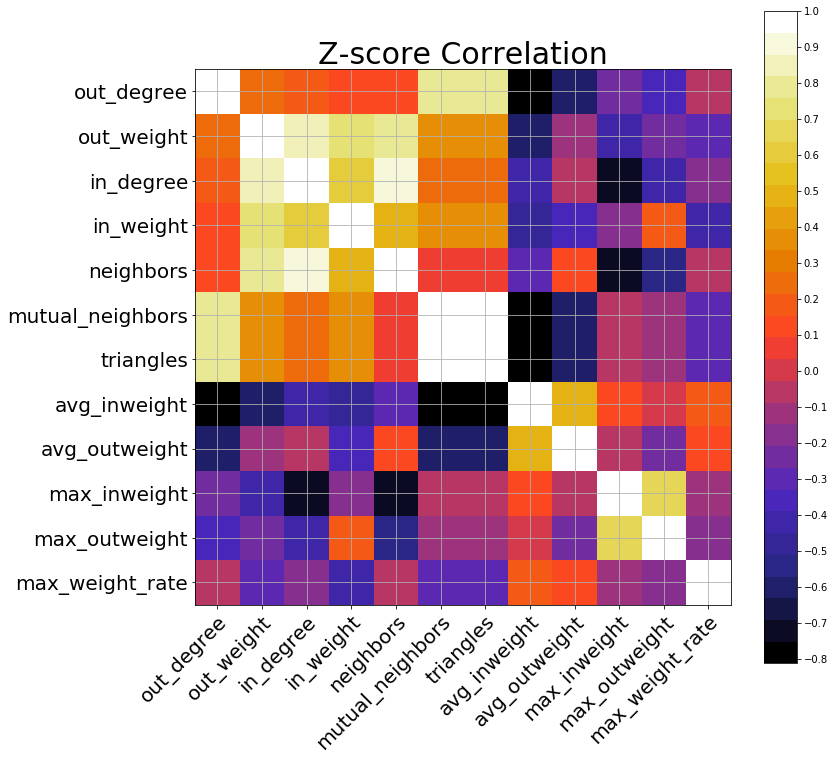

In [158]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=[12,12])
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('CMRmap', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Z-score Correlation', fontsize=30)
    labels=df.columns
    ax1.set_xticks(np.arange(len(df)))
    ax1.set_xticklabels(labels,fontsize=20)
    ax1.set_yticks(np.arange(len(df)))
    ax1.set_yticklabels(labels,fontsize=20)
    
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=pd.Series(np.arange(-1,1.1,0.1)))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
#     plt.savefig("Zscore_corr")
    plt.show()

correlation_matrix(df)

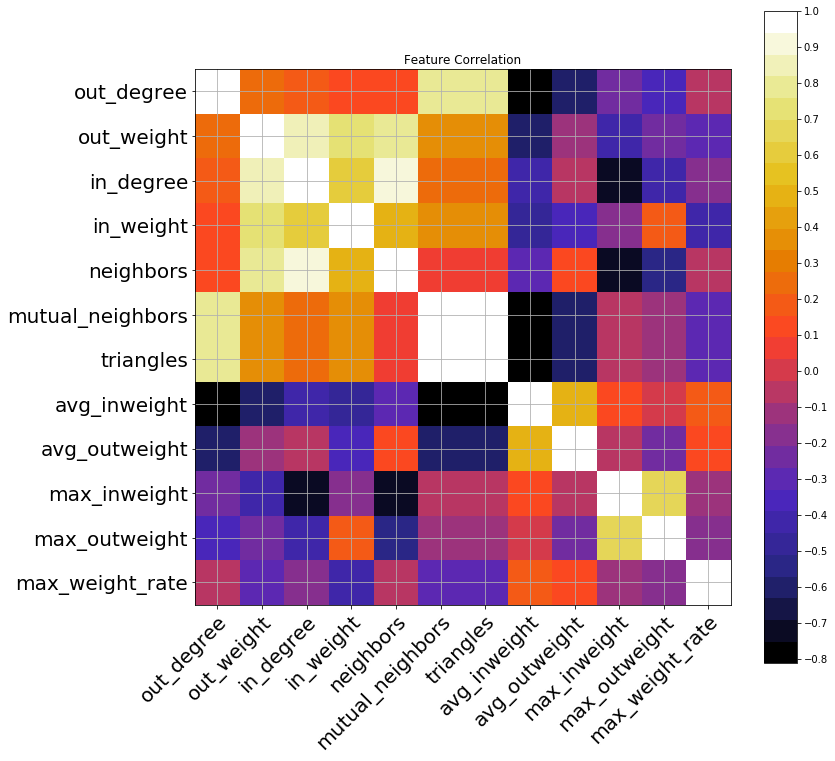

In [152]:
z_mat = np.array(z_collection)
df = pd.DataFrame(np.corrcoef(z_mat))
df.columns = ["out_degree", "out_weight", "in_degree", "in_weight", "neighbors", "mutual_neighbors", "triangles", "avg_inweight", "avg_outweight", "max_inweight", "max_outweight", "max_weight_rate"]
correlation_matrix(df)
# df.set_xticklabels(labels,fontsize=6)
# plt.matshow(df)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=10)

In [197]:
import math
import scipy.stats as ss

def entropy(x): 
    total = sum(x) # 
    x = [xi / total for xi in x] # 
    H = sum([-xi * math.log2(xi +1e20) for xi in x]) # 
    return H

for tens in travel_tensor:
    adjmat = tens[:,:226]
    G=nx.from_numpy_matrix(adjmat)
    centrality = nx.eigenvector_centrality(G)
    centrality
    print(entropy(centrality))
    
# U, S, V =np.linalg.svd(adjmat)
# print(entropy(U[1]))

-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189774723
-66.43856189

In [166]:
scipy.stats

AttributeError: module 'scipy' has no attribute 'stats'

In [4]:
fromto_df = pd.read_csv("global_from_to.csv")

In [5]:
G = serial_graphs[10]

In [6]:
# elarge = [(u, v) for (u,v, d) in G.edges(data=True) if d['weight'] > 4]

In [7]:
selected_nodes = [n for n,v,d in G.edges(data=True) if d['weight'] > 2]  
print (np.unique(selected_nodes))

['BE' 'BY' 'ES' 'GB' 'IQ' 'PH' 'QA' 'TH' 'US']


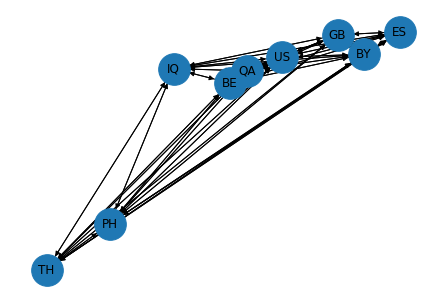

In [8]:
H = G.subgraph(selected_nodes)
nx.draw(H,with_labels=True,node_size=1000)
# plt.figure(figsize=(20,20))

In [9]:
# H.in_degree('IT')
list(H.in_degree(np.unique(selected_nodes)))

[('BE', 9),
 ('BY', 9),
 ('ES', 9),
 ('GB', 9),
 ('IQ', 9),
 ('PH', 9),
 ('QA', 9),
 ('TH', 9),
 ('US', 9)]

In [10]:
# Initialize Graph model. 
G3 = nx.DiGraph()
G3.add_edge('KR','US')
G3.add_edge('US','KR')
# nodes = travel_df['node'].unique().T
# for u in nodes:
#     for v in nodes:
#         G.add_edge(u,v)
#         G[u][v]['weight'] = 0

In [11]:
# G3.edges()
G3['KR']['US']['weight'] =1

In [12]:
G3.get_edge_data('KR','US')
G3.get_edge_data('US','KR')

{}

In [20]:
G3.in_degree('KR')
[n for n,v,d in G.edges(data=True) if d['weight'] > 1]  

['US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'FR',
 'CO',
 'BR',
 'BR',
 'ID',
 'ID',
 'JP',
 'GB',
 'GB',
 'GB',
 'GB',
 'MX',
 'CR',
 'PH',
 'PH',
 'PH',
 'ES',
 'ES',
 'ES',
 'ES',
 'HK',
 'AU',
 'IT',
 'TH',
 'TH',
 'TH',
 'RU',
 'RU',
 'RU',
 'NZ',
 'CN',
 'AR',
 'NL',
 'NL',
 'JO',
 'MY',
 'MY',
 'MY',
 'SG',
 'SG',
 'SG',
 'QA',
 'QA',
 'DO',
 'PT',
 'BE',
 'BE',
 'GR',
 'EE',
 'LV',
 'UA',
 'LA',
 'HT',
 'BY',
 'IQ']